# Object Detection Notebook using IceVision

Using Singularity container w/ IceVision v0.5.2 (https://airctic.com/0.5.2/)

In [1]:
from icevision.all import *
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, recall_score

In [270]:
#set directories
root_dir = "/work/ih49/simulations/"
base_dir = root_dir + 'model_misspecification/'

#testing run on full ancestry images
path = Path(base_dir + 'admix_gen_100/')

In [271]:
fnames = get_image_files(path)

Calculate bounding box vertices as 5 pixels +/- the variant position. Variant location (physical position) is taken from the image file name, and converted to pixel coordinates.

Bbox is formated as \[xmin, ymin, xmax, ymax\], with indices started at 0 from the bottom left corner.

In [272]:
pos = [int(re.search("pos-(.*)_seed", str(i)).group(1)) for i in fnames]
bbox_xmin = [math.ceil((i / 50e6) * 200) - 5 for i in pos]
labl_bbox = [[i, 0, i + 11, 200] for i in bbox_xmin]
image_id = [re.search("(.*.png)", str(i)).group(1) for i in fnames]

Combine image filename, image width, image height, bbox, and source \[which is the "images" directory\] in dataframe (for input to icevision parser).

In [273]:
df = pd.DataFrame(list(zip(image_id, [200] * len(image_id), [200] * len(image_id), labl_bbox, [str(path) for i in image_id])), 
               columns =['image_id', 'width', 'height', 'bbox', 'source'])

Creat custom parser. I followed [this tutorial](https://airctic.com/0.5.2/custom_parser/) with some modifications.

In [220]:
class VariantParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [221]:
VariantParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [222]:
class VariantParser(parsers.FasterRCNN, parsers.FilepathMixin, parsers.SizeMixin):
    def __init__(self, df, source):
        self.df = df
        self.source = source

    def __iter__(self):
        yield from self.df.itertuples()

    def __len__(self):
        return len(self.df)

    def imageid(self, o) -> Hashable:
        return o.image_id

    def filepath(self, o) -> Union[str, Path]:
        return self.source / f"{o.image_id}"

    def image_width_height(self, o) -> Tuple[int, int]:
        return get_image_size(self.filepath(o))

    def labels(self, o) -> List[int]:
        return [1]

    def bboxes(self, o) -> List[BBox]:
        return [BBox.from_xyxy(*np.fromiter(o.bbox, dtype="int"))]

Create class map. This is necessary, even though there is only one class.

In [223]:
class_map = ClassMap(['selected_variant'])

Split data to training and validation records. I set a random seed so we can be comparing with the same train/valid sets. 8000 images in training set, 2000 in validation set.

This may take a couple minutes to run.

In [274]:
parser = VariantParser(df, path)
train_rs, valid_rs = parser.parse(data_splitter=RandomSplitter([0, 1], seed=42))

  0%|          | 0/1000 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:126
AUTOFIX-START - ️🔨  Autofixing record with imageid: 210  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmax from 202 to image width 200 (Before: <BBox (xmin:191, ymin:0, xmax:202, ymax:200)>) | icevision.core.bbox:autofix:77
AUTOFIX-START - ️🔨  Autofixing record with imageid: 439  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmax from 206 to image width 200 (Before: <BBox (xmin:195, ymin:0, xmax:206, ymax:200)>) | icevision.core.bbox:autofix:77
AUTOFIX-START - ️🔨  Autofixing record with imageid: 652  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmin from -4 to 0 (Before: <BBox (xmin:-4, ymin:0, xmax:7, ymax:200)>) | icevision.core.bbox:autofix:63
AUTOFIX-START - ️🔨  Autofixing record with imageid: 548  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmax from 204 to image width 200 (Before: <BBox (xmin:193, ym

AUTOFIX-START - ️🔨  Autofixing record with imageid: 422  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmin from -1 to 0 (Before: <BBox (xmin:-1, ymin:0, xmax:10, ymax:200)>) | icevision.core.bbox:autofix:63
AUTOFIX-START - ️🔨  Autofixing record with imageid: 728  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmin from -2 to 0 (Before: <BBox (xmin:-2, ymin:0, xmax:9, ymax:200)>) | icevision.core.bbox:autofix:63
AUTOFIX-START - ️🔨  Autofixing record with imageid: 703  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmin from -2 to 0 (Before: <BBox (xmin:-2, ymin:0, xmax:9, ymax:200)>) | icevision.core.bbox:autofix:63
AUTOFIX-START - ️🔨  Autofixing record with imageid: 172  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmin from -1 to 0 (Before: <BBox (xmin:-1, ymin:0, xmax:10, ymax:200)>) | icevision.core.bbox:autofix:63
AUTOFIX-START - ️🔨  Autofixing record with imageid: 423  ️

AUTOFIX-START - ️🔨  Autofixing record with imageid: 229  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmax from 206 to image width 200 (Before: <BBox (xmin:195, ymin:0, xmax:206, ymax:200)>) | icevision.core.bbox:autofix:77
AUTOFIX-START - ️🔨  Autofixing record with imageid: 419  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmax from 203 to image width 200 (Before: <BBox (xmin:192, ymin:0, xmax:203, ymax:200)>) | icevision.core.bbox:autofix:77
AUTOFIX-START - ️🔨  Autofixing record with imageid: 765  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmin from -3 to 0 (Before: <BBox (xmin:-3, ymin:0, xmax:8, ymax:200)>) | icevision.core.bbox:autofix:63
AUTOFIX-START - ️🔨  Autofixing record with imageid: 913  ️🔨 | icevision.core.record:_pre_replay:89
AUTOFIX-SUCCESS - Clipping bbox xmin from -1 to 0 (Before: <BBox (xmin:-1, ymin:0, xmax:10, ymax:200)>) | icevision.core.bbox:autofix:63
AUTOFIX-START - ️🔨  Aut

Make sure everything looks correct.

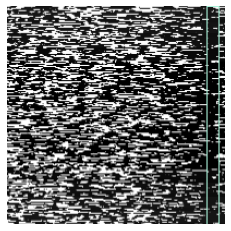

In [275]:
show_record(valid_rs[60], display_label=False)

In [276]:
len(train_rs), len(valid_rs)

(0, 1000)

In [277]:
train_ds = Dataset(train_rs)
valid_ds = Dataset(valid_rs)

Create dataloaders and define the model we're using ([FasterRCNN](https://airctic.com/0.5.2/model_faster_rcnn/), resnet18 architecture)

In [278]:
#train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [229]:
backbone = faster_rcnn.backbones.resnet_fpn.resnet18(pretrained=True)

Define custom metrics & wrap in Metric class

* Center proportion (center_metric) = proportion of predicted bboxes that contain the selected variant. (should be close to 1)
* Average width (width_metric) = average width of bboxes (should be ~11 pixels wide)
* Number of boxes (num_bboxes) = average number of predicted bboxes per image (should be close to 1)

In [16]:
def center_metric(sample, pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    bbox_sample = sample['bboxes'][0]
    bbox_xaxis_sample = bbox_sample.xyxy[0:3:2]
    sample_midpoint = math.ceil((bbox_xaxis_sample[0] + bbox_xaxis_sample[1])/2)
    center_in_bbox = [i[1] >= sample_midpoint >= i[0] for i in bbox_xaxis_pred]
    center_accuracy_mean = np.mean(center_in_bbox)
  else:
    center_accuracy_mean = 0
  return center_accuracy_mean

def width_metric(pred):
  bbox_pred = pred['bboxes']
  if len(bbox_pred)>0:
    bbox_xaxis_pred = [i.xyxy[0:3:2] for i in bbox_pred]
    pred_width = [i[1] - i[0] for i in bbox_xaxis_pred]
    pred_width_mean = np.mean(pred_width)
  else:
    pred_width_mean = None
  return pred_width_mean
  

def num_bboxes(pred):
  num_boxes = len(pred['bboxes'])
  return num_boxes

In [326]:
def precision_recall_metric(samples, preds, detection_threshold=0.5):
    sample_all_true = []
    pred_all_true = []
    for i in range(len(samples)):
        sample_bbox_true = [0] * 200
        sample_bbox_xmin, sample_bbox_xmax = samples[i]['bboxes'][0].xyxy[0:3:2]
        sample_bbox_true[sample_bbox_xmin:sample_bbox_xmax] = [1] * (sample_bbox_xmax - sample_bbox_xmin)
        sample_all_true.extend(sample_bbox_true)
        
        pred_bbox_true = [0] * 200
        bbox_pred = [preds[i]['bboxes'][e] for e in range(len(preds[i]['scores'])) if preds[i]['scores'][e] >= detection_threshold]
        if len(bbox_pred)>0:
            bbox_xaxis_pred = [bbox.xyxy[0:3:2] for bbox in bbox_pred]
            for j in bbox_xaxis_pred:
                bbox_min = round(j[0])
                bbox_max = round(j[1])
                if bbox_min < 0:
                    bbox_min = 0
                if bbox_max > 200:
                    bbox_max = 200
                pred_bbox_true[bbox_min:bbox_max] = [1] * (bbox_max - bbox_min)        
        pred_all_true.extend(pred_bbox_true)
    bbox_precision = precision_score(sample_all_true, pred_all_true, zero_division=1)
    bbox_recall = recall_score(sample_all_true, pred_all_true)
    return_dict = {"Precision": bbox_precision, "Recall": bbox_recall, "Threshold": detection_threshold}
    return return_dict

For all metrics, the idea here is to calculate the metric for all validation records (2000 images) and collect them by batches (accumulate), and average across all records at the end of each epoch (finalize). Then, the accumulated metrics need to be cleared at the end of each epoch so that they can be calculated anew the next cycle.

For average widths: some records will have no predicted bboxes, so the average is not calculated for those values. That is, we calculate the average width only for those bboxes that are predicted. So the denominator may be more or less than the actual number of valiation records. This value will likely be None in the first epoch because no bboxes will be predicted.

In [17]:
class Center_Proportion(Metric):
    def __init__(self):
        self._props = []

    def _reset(self):
        self._props.clear()

    def accumulate(self, records, preds):
        center_results = [center_metric(sample, pred) for sample, pred in zip(records,preds)]
        self._props.extend(center_results)

    def finalize(self) -> Dict[str, float]:
        final_prop = np.mean(self._props)
        self._reset()
        return {'Center_in_Bbox': final_prop}

class Avg_Width(Metric):
    def __init__(self):
        self._widths = []

    def _reset(self):
        self._widths.clear()

    def accumulate(self, records, preds):
        width_results = [width_metric(pred) for pred in preds]
        for i in width_results:
          if i:
            self._widths.append(i)
          else:
            pass

    def finalize(self) -> Dict[str, float]:
        if self._widths:
          final_avg = np.mean(self._widths)
        else:
          final_avg = None
        self._reset()
        return {'Width_Bbox': final_avg}

class Num_Bboxes(Metric):
    def __init__(self):
        self._num = []

    def _reset(self):
        self._num.clear()

    def accumulate(self, records, preds):
        num_boxes_results = [num_bboxes(pred) for pred in preds]
        self._num.extend(num_boxes_results)

    def finalize(self) -> Dict[str, float]:
        final_num = np.mean(self._num)
        self._reset()
        return {'Num_Bbox': final_num}

### Skip training and start here to load model weights!

In [279]:
model = faster_rcnn.model(backbone=backbone, num_classes=len(class_map))
model.load_state_dict(torch.load('object_localization_full-ancestry.model.pth', map_location=torch.device('cuda')))

<All keys matched successfully>

Make sure results are the same when loading the pretrained weights.

In [280]:
infer_dl = faster_rcnn.infer_dl(valid_ds, batch_size=16)
samples, preds = faster_rcnn.predict_dl(model.cuda(), infer_dl)

  0%|          | 0/63 [00:00<?, ?it/s]

In [281]:
center_results = [center_metric(sample, pred) for sample, pred in zip(samples,preds)]
num_boxes_results = [num_bboxes(pred) for pred in preds]
width_results = [width_metric(pred) for pred in preds]
final_widths = []
for i in width_results:
    if i:
      final_widths.append(i)
    else:
      pass
np.mean(center_results), np.mean(num_boxes_results), np.mean(final_widths), precision_recall_metric(samples, preds)

(0.97775,
 1.014,
 10.815544,
 'Precision: 0.9145858288030959; Recall: 0.915598192048704')

In [214]:
center_results = [center_metric(sample, pred) for sample, pred in zip(samples2,preds2)]
num_boxes_results = [num_bboxes(pred) for pred in preds2]
width_results = [width_metric(pred) for pred in preds2]
final_widths = []
for i in width_results:
    if i:
      final_widths.append(i)
    else:
      pass
np.mean(center_results), np.mean(num_boxes_results), np.mean(final_widths), precision_recall_metric(samples2, preds2)

(0.95,
 1.027,
 10.825825,
 'Precision: 0.8862838115221456; Recall: 0.8971695063951609')

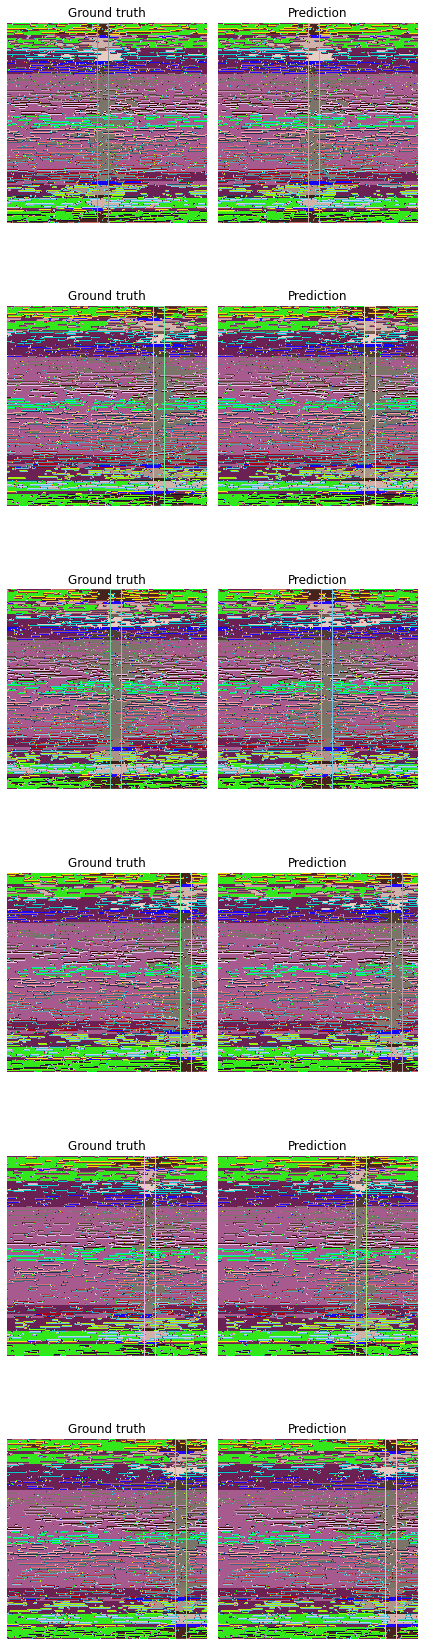

In [233]:
show_preds(samples[:6], preds[:6], class_map, display_label=False, display_mask=False)

Looking good!!!!

In [24]:
samples3, preds3 = faster_rcnn.predict_dl(model2.cuda(), infer_dl, detection_threshold=0)

  0%|          | 0/125 [00:00<?, ?it/s]

In [25]:
pd.DataFrame(preds3).to_csv("object_localization_full_ancestry_THRESHOLD-0_preds.txt", sep='\t', header=True, index=False)

In [27]:
pd.DataFrame(samples3).to_csv("object_localization_full_ancestry_THRESHOLD-0_targets.txt", sep='\t', header=True, index=False, columns=['imageid','bboxes','labels','filepath'])

In [330]:
thresholds = np.linspace(0,1,100)

precision_recall_curve = [precision_recall_metric(samples, preds, threshold) for threshold in thresholds]


/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [335]:
pd.DataFrame(precision_recall_curve).to_csv("~/Test.txt")